In [1]:
import concurrent.futures
import matplotlib.pyplot as plt
# import pprint
import random
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed, wait
%matplotlib inline

In [2]:
from helpers import fake_io, n_fibonacci, digits_fibonacci

In [3]:
random.seed(42)
# print = pprint.pprint

Our 'data processing' consists in calculating the nth Fibonacci number $F_n$, given an input $n$.

The Fibonacci sequence is defined as follows:

$$
F_n = F_{n-1} + F_{n-2}
$$
with seed values $F_0 = 0$ and $F_1 = 1$ [see more].

[see more]: https://en.wikipedia.org/wiki/Fibonacci_number

In [4]:
fibonacci_sequence = [
    n_fibonacci(n) for n in range(10)
]
fibonacci_sequence

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

In [5]:
%time n_fibonacci(10)
# random.random()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


55

In [6]:
%time n_fibonacci(20000)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.6 ms


2531162323732361242240155003520607291766356485802485278951929841991312781760541315230153423463758831637443488219211037689033673531462742885329724071555187618026931630449193158922771331642302030331971098689235780843478258502779200293635651897483309686042860996364443514558772156043691404155819572984971754278513112487985892718229593329483578531419148805380281624260900362993556916638613939977074685016188258584312329139526393558096840812970422952418558991855772306882442574855589237165219912238201311184749075137322987656049866305366913734924425822681338966507463855180236283582409861199212323835947891143765414913345008456022009455704210891637791911265475167769704477334859109822590053774932978465651023851447920601310106288957894301592502061560528131203072778677491443420921822590709910448617329156135355464620891788459566081572824889514296350670950824208245170667601726417091127999999941149913010424532046881958285409468463211897582215075436515584016297874572183907949257286261608612401379639484713

In [7]:
%time digits_fibonacci(int(2E5))

CPU times: user 480 ms, sys: 0 ns, total: 480 ms
Wall time: 482 ms


41798

In [8]:
input_numbers = [
    int(2E5) + random.randint(-1E5, 1E5) // 2 for __ in range(16)
]
print(input_numbers)

[233810, 164592, 153278, 247196, 186048, 182098, 179256, 168289, 246530, 163434, 238696, 247080, 221482, 161395, 227397, 205302]


We should factor in the time it takes to read the input and write the output in a normal situation...

In [9]:
%%time
data_in = fake_io(int(2e4)) # e.g read data from disk/API
n_digits = digits_fibonacci(data_in)
print(fake_io(n_digits)) # e.g. write data to disk/API

4180
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 445 ms


In [10]:
%%time
for n in input_numbers:
    fake_io(n) # e.g read data from disk/API
    n_digits = digits_fibonacci(n)
    print(fake_io(n_digits), end=" ") # e.g. write data to disk/API

48864 34398 32033 51661 38882 38056 37462 35170 51522 34156 49885 51637 46287 33730 47523 42906 CPU times: user 7.66 s, sys: 4 ms, total: 7.66 s
Wall time: 16.8 s


In [11]:
start = time.time()
seq_checkpoints = []
seq_checkpoints.append(time.time() - start)
for n in input_numbers:
    fake_io(n) # e.g read data from disk/API
    seq_checkpoints.append(time.time() - start)
    n_digits = digits_fibonacci(n)
    seq_checkpoints.append(time.time() - start)
    print(fake_io(n_digits), end=" ") # e.g. write data to disk/API
    seq_checkpoints.append(time.time() - start)

48864 34398 32033 51661 38882 38056 37462 35170 51522 34156 49885 51637 46287 33730 47523 42906 

(0, 4)

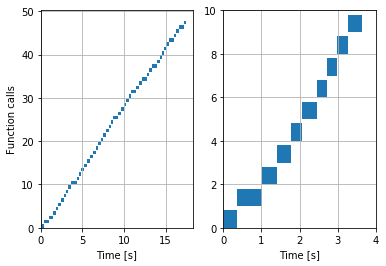

In [12]:
seq_widths = [
    x - y for x, y in zip(seq_checkpoints[1:], seq_checkpoints[:-1])
]
# plt.figure(figsize=(12,8))
fig, axes = plt.subplots(1, 2)
# plt.title("Functions time usage")
for ax in axes:
    ax.barh(range(len(seq_checkpoints[1:])), seq_widths, left=seq_checkpoints[:-1], align='edge')
    ax.set_ylim((0, None))
    ax.set_xlabel("Time [s]")
#     plt.xlabel("Time [s]")
    ax.grid()
axes[0].set_ylabel("Function calls")
axes[1].set_ylim((0,10))
axes[1].set_xlim((0,4))
# plt.plot(seq_checkpoints[::2], 'o-')

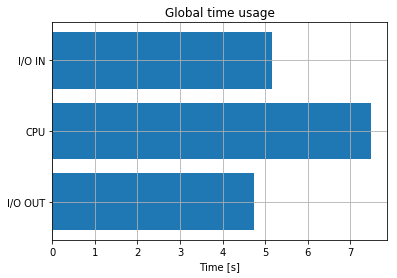

In [13]:
io_in = sum(seq_widths[::3])
cpu = sum(seq_widths[1::3])
io_out = sum(seq_widths[2::3])

ax = plt.barh(range(3), [io_out, cpu, io_in])
plt.title("Global time usage")
plt.xlabel("Time [s]")
# plt.ylabel("Function calls")
plt.yticks(range(3), ("I/O OUT", "CPU", "I/O IN"))
plt.grid()

In [14]:
start = time.time()
pp_chkpts = []
pp_chkpts.append(time.time() - start)
with ProcessPoolExecutor() as pp:
    data_in = list(pp.map(fake_io, input_numbers)) # e.g read data from disk/API
    pp_chkpts.append(time.time() - start)
    processed_data = list(pp.map(digits_fibonacci, data_in))
    pp_chkpts.append(time.time() - start)
    data_out = pp.map(fake_io, processed_data) # e.g. write data to disk/API
    print(list(data_out))
    pp_chkpts.append(time.time() - start)
print("{} secs".format(time.time() - start))

[48864, 34398, 32033, 51661, 38882, 38056, 37462, 35170, 51522, 34156, 49885, 51637, 46287, 33730, 47523, 42906]
5.238773822784424 secs


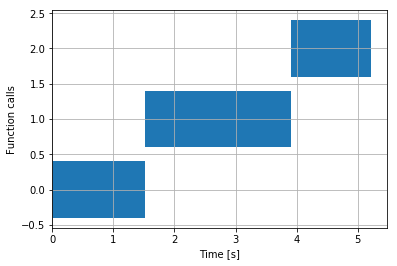

In [15]:
pp_widths = [
    x - y for x, y in zip(pp_chkpts[1:], pp_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(pp_chkpts[1:])), pp_widths, left=pp_chkpts[:-1])
# plt.plot(pp_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
plt.ylabel("Function calls")
plt.grid()

In [16]:
def process_datum(n):
    m = fake_io(n) # e.g read data from disk/API
    n_digits = digits_fibonacci(m)
    return fake_io(n_digits) # e.g. write data to disk/API

In [17]:
%%time
with ProcessPoolExecutor() as pp:
    print(list(pp.map(process_datum, input_numbers)))

[48864, 34398, 32033, 51661, 38882, 38056, 37462, 35170, 51522, 34156, 49885, 51637, 46287, 33730, 47523, 42906]
CPU times: user 12 ms, sys: 16 ms, total: 28 ms
Wall time: 4.99 s


In [18]:
%%time
start = time.time()
pt_chkpts = []
pt_chkpts.append(time.time() - start)
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        data_in = list(tp.map(fake_io, input_numbers))
        pt_chkpts.append(time.time() - start)
        processed_data = list(pp.map(digits_fibonacci, data_in))
        pt_chkpts.append(time.time() - start)
        data_out = tp.map(fake_io, processed_data)
        print(list(data_out))
        pt_chkpts.append(time.time() - start)
#         print(list(tp.map(fake_io, processed_data)))

[48864, 34398, 32033, 51661, 38882, 38056, 37462, 35170, 51522, 34156, 49885, 51637, 46287, 33730, 47523, 42906]
CPU times: user 36 ms, sys: 24 ms, total: 60 ms
Wall time: 3.09 s


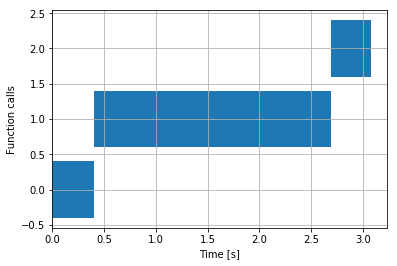

In [19]:
pt_widths = [
    x - y for x, y in zip(pt_chkpts[1:], pt_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(pt_chkpts[1:])), pt_widths, left=pt_chkpts[:-1])
# plt.plot(pt_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
plt.ylabel("Function calls")
plt.grid()

In [20]:
%%time
start = time.time()
tt_chkpts = []
tt_chkpts.append(time.time() - start)
with ThreadPoolExecutor() as tp:
        data_in = [
            tp.submit(fake_io, i) for i in input_numbers
        ]
        # This slows down things but it's necessary for recording time
        wait(data_in)
        tt_chkpts.append(time.time() - start)
        processed_data = [
            digits_fibonacci(f.result()) for f in as_completed(data_in)
        ]
        tt_chkpts.append(time.time() - start)
        data_out = [
            tp.submit(fake_io, d) for d in processed_data
        ]
        for f in as_completed(data_out):
            print(f.result())
        tt_chkpts.append(time.time() - start)
#         print(list(tp.map(fake_io, processed_data)))

35170
32033
34398
37462
34156
51661
38882
46287
48864
42906
51522
38056
33730
49885
51637
47523
CPU times: user 7.3 s, sys: 72 ms, total: 7.37 s
Wall time: 8.07 s


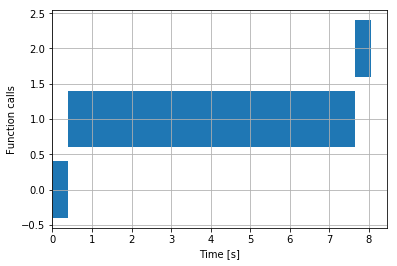

In [21]:
tt_widths = [
    x - y for x, y in zip(tt_chkpts[1:], tt_chkpts[:-1])
]
# plt.figure(figsize=(12,8))
plt.barh(range(len(tt_chkpts[1:])), tt_widths, left=tt_chkpts[:-1])
# plt.plot(tt_chkpts[::2], 'o-')
plt.xlabel("Time [s]")
plt.ylabel("Function calls")
plt.grid()

### Summary

Let's summarize the performance of different configurations.

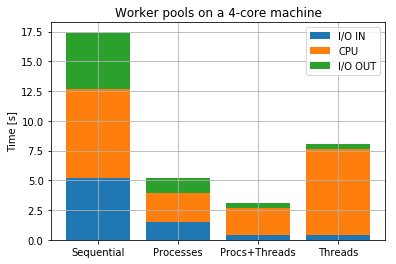

In [22]:
io_in, cpu, io_out = [], [], []
options = {
    "Sequential": seq_widths,
    "Processes": pp_widths,
    "Procs+Threads": pt_widths,
    "Threads": tt_widths
}

# plt.figure(figsize=(14,4))
for name, widths in options.items():
    io_in.append(
        sum(widths[::3])
    )
    cpu.append(
        sum(widths[1::3])
    )
    io_out.append(
        sum(widths[2::3])
    )
plt.bar(range(4), io_in, label="I/O IN")
plt.bar(range(4), cpu, bottom=io_in, label="CPU")
plt.bar(range(4), io_out, bottom=[a + b for a,b in zip(cpu, io_in)], label="I/O OUT")
plt.xticks(range(4), (
    "Sequential",
    "Processes",
    "Procs+Threads",
    "Threads",
))
plt.ylabel("Time [s]")
plt.title("Worker pools on a 4-core machine")
plt.grid()
plt.legend();

### Scaling with number of tasks

CPU times: user 8.45 s, sys: 2.68 s, total: 11.1 s
Wall time: 27.5 s


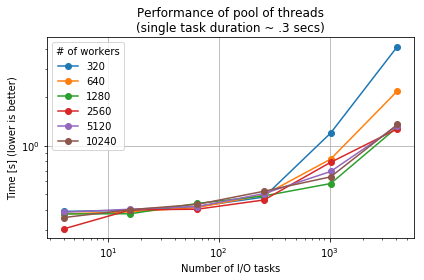

In [23]:
%%time
times = []
th_startups = []
task_numbers = [2**x for x in range(2, 13, 2)] 
workers_numbers = [5*2**x for x in range(6, 12)]
for n_workers in workers_numbers:
    startup_start = time.time()
    with ThreadPoolExecutor(n_workers) as tp:
        th_startups.append(time.time() - startup_start)
        for n_tasks in task_numbers:
            start = time.time()
            list(tp.map(fake_io, range(n_tasks)))
            times.append(time.time() - start)
    plt.plot(task_numbers, times, '-o', label=n_workers)
    times = []
plt.grid()
plt.legend(title="# of workers")
plt.title("Performance of pool of threads\n(single task duration ~ .3 secs)")
plt.ylabel("Time [s] (lower is better)")
plt.xlabel("Number of I/O tasks");
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig("images/threads.png", dpi=150);

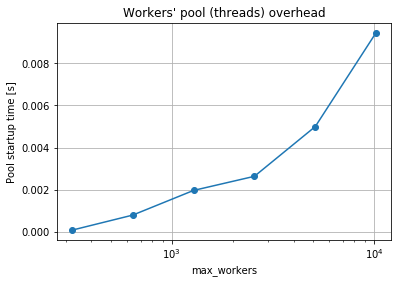

In [24]:
plt.plot(workers_numbers, th_startups, 'o-')
plt.title("Workers' pool (threads) overhead")
plt.xlabel("max_workers")
plt.ylabel("Pool startup time [s]")
plt.xscale('log')
plt.grid();